## Imports

In [1]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import torch
from torch import nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from scipy.interpolate import interp1d
import copy

## Training Function

In [302]:
def global_loss(Mlp,Classic):

    # Init
    num_point = 500
    criterion = nn.MSELoss() 
    mlps = []
    losses = []
    
    for i in range(1,28):
        
        # Train
        Classic.set_waveform(i)
        Mlp.train()
        Mlp.init_weights()
        Mlp = train_mlp(Mlp,Classic)
        Mlp.eval()

        # Eval
        input = torch.linspace(0,1,num_point).unsqueeze(1)
        exact_output = Classic(input)
        pred_output = Mlp(input)

        # Store
        mlps.append(copy.deepcopy(Mlp.state_dict()))
        losses.append(criterion(exact_output,pred_output).item())
    
    return mlps, losses
    
def train_mlp(Mlp, Classic):
    batch = 100
    EPOCH_LOSS = []
    BEST_LOSS = torch.inf
    COUNT = 0
    criterion = nn.MSELoss()  # MSE loss
    criterion = torch.nn.L1Loss()
    optimizer = optim.Adam(Mlp.parameters(),lr=0.01)  # Adam optimizer

    for i in range(10000):  # Assuming you want to run 100 epochs
        input = torch.rand((batch, 1), dtype=torch.float)  # Random input between 0 and 1
        expected_output = Classic(input).float()
        predicted_output = Mlp(input).float()

        # Calculate the loss
        loss = criterion(predicted_output, expected_output)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the loss
        EPOCH_LOSS.append(loss.item())

        if EPOCH_LOSS[-1] > BEST_LOSS:
            COUNT += 1
            if COUNT>100:
                break
        else:
            COUNT = 0
            BEST_LOSS = EPOCH_LOSS[-1]
    return Mlp

def plot_waves(Mlp, Classic, mlps, num_points=100):
    
    Mlp.eval()
    # Calculate number of rows needed for subplots
    num_models = len(mlps)
    plt.style.use('dark_background')
    fig, axs = plt.subplots((2+num_models)//3, 3, figsize=(12, (4*num_models)//3))  # Adjust figsize as needed

    axs = axs.flatten()
    
    for i, mlp_params in enumerate(mlps):

        # Load model parameters
        Mlp.load_state_dict(mlp_params)
        Classic.set_waveform(i+1)

        Mlp.plot(axs[i],num_points)
        Classic.plot(axs[i],num_points)
        
        # Setting titles and labels
        axs[i].set_title(f'Waveform {i+1}')
        axs[i].grid(True, which='both', linestyle='-', color='lightblue', linewidth=0.5)
        axs[i].set_facecolor('#0e1117')  # Background color
        axs[i].set_xlabel('Input')
        axs[i].set_ylabel('Output')
        axs[i].legend()
    
    plt.tight_layout()
    plt.show()

# Models

## 0. Classic

In [300]:
def overdrive(signal, gain, threshold):
    """
    Applies overdrive effect to the signal.
    
    Parameters:
    - signal: Input audio signal.
    - gain: Amplification factor before clipping.
    - threshold: Threshold for clipping.
    
    Returns:
    - Processed audio signal with overdrive effect.
    """
    # Apply gain
    processed_signal = signal * gain
    # Clip the signal
    processed_signal = np.clip(processed_signal, -threshold, threshold)
    return processed_signal

def saturation(signal, level):
    """
    Applies saturation effect to the signal.
    
    Parameters:
    - signal: Input audio signal.
    - level: Saturation level.
    
    Returns:
    - Processed audio signal with saturation effect.
    """
    # Apply saturation
    processed_signal = np.tanh(level * signal)
    return processed_signal

def bit_reduction(signal, bit_depth):
    """
    Applies bit reduction effect to the signal.
    
    Parameters:
    - signal: Input audio signal.
    - bit_depth: Desired bit depth.
    
    Returns:
    - Processed audio signal with bit reduction effect.
    """
    # Calculate step size
    step = 2 ** (-bit_depth)
    # Quantize the signal
    processed_signal = np.round(signal / step) * step
    return processed_signal

def interpolate_waveform(waveform, x):
    # Extract x and y values from the waveform
    x_points, y_points = waveform[:, 0], waveform[:, 1]

    # Create a linear interpolation function
    linear_interpolator = interp1d(x_points, y_points, kind='linear', fill_value='extrapolate')

    # Get the interpolated y value for the provided x value
    y_interpolated = linear_interpolator(x)

    return y_interpolated

class WaveShaperClassic():
    def __init__(self,parameters = None,waveforms = None,wave_number = 1):

        self.parameters = parameters

        self.waveforms = waveforms
        self.wave_number = str(wave_number)
        if self.waveforms is not None:
            self.wave = self.waveforms[self.wave_number]
    
    def set_waveform(self,wave_number):
        self.wave_number = str(wave_number)
        if self.waveforms is not None:
            self.wave = self.waveforms[self.wave_number]


    def forward(self,signal):

        signal = signal.numpy()

        if self.parameters is not None:
            if self.parameters["overdrive"]:
                signal = overdrive(signal,self.parameters["overdrive"]["gain"],self.parameters["overdrive"]["threshold"])
            
            if self.parameters["saturation"]:
                signal = overdrive(signal,self.parameters["saturation"]["level"])
            
            if self.parameters["bit_reduction"]:
                signal = overdrive(signal,self.parameters["bit_reduction"]["bit_depth"])
            
        elif self.waveforms is not None:
            signal = interpolate_waveform(self.wave, signal)
        
        return torch.tensor(signal)
    
    def __call__(self, signal):
        return self.forward(signal)
    
    def plot(self, axe, num_points=100):
        
        # Generate inputs and predictions
        #try:
        #    self.eval()
        #except:
        #    pass
        inputs = torch.linspace(0, 1, num_points).unsqueeze(1)
        predicted_output = self(inputs).detach()
    
        axe.plot(inputs.squeeze().numpy(), 
                 predicted_output.squeeze().numpy(), 
                 label='Predicted Output', 
                 color='white',alpha = 0.6)
    

waveforms = np.load('WaveShaperShapes/waveforms.npy',allow_pickle=True).item()

classic_WaveShaper = WaveShaperClassic(waveforms=waveforms,wave_number=13)
WaveShaper_Classic = WaveShaperClassic(waveforms=waveforms,wave_number=13)

## 1. MLP

In [2]:
class WaveShaperMLP(nn.Module):
    def __init__(self, num_neurons_list, activations_list, dropout_rate=0.5):
        super(WaveShaperMLP, self).__init__()
        self.linear_layers = nn.ModuleList()  # Separate ModuleList for linear layers
        self.dropout_layers = nn.ModuleList()  # Separate ModuleList for dropout layers
        self.activations_info = activations_list

        # Create linear and dropout layers based on num_neurons_list
        for i in range(len(num_neurons_list) - 1):
            linear_layer = nn.Linear(num_neurons_list[i], num_neurons_list[i+1])
            self.linear_layers.append(linear_layer)
            
            if i < len(num_neurons_list) - 2:  # No dropout after the last linear layer
                dropout_layer = nn.Dropout(dropout_rate)
                self.dropout_layers.append(dropout_layer)

        # Initialize weights
        self.init_weights()

    def forward(self, x):
        for i, linear_layer in enumerate(self.linear_layers):
            x = linear_layer(x)
            relu_number = int(x.shape[1] * self.activations_info[i])

            if i == len(self.linear_layers)-1:
                pass
            else:
                x[:,:relu_number] = F.relu(x[:,:relu_number])
                #x[:,:relu_number] = F.leaky_relu(x[:,:relu_number]) Null outputs solved
                x[:,relu_number:] = torch.sigmoid(x[:,relu_number:])
                x = self.dropout_layers[i](x)
                
        return x

    def init_weights(self):
        for linear_layer in self.linear_layers:
            nn.init.xavier_uniform_(linear_layer.weight)
            nn.init.zeros_(linear_layer.bias)

    def plot(self, axe, num_points=500):
        
        # Generate inputs and predictions
        self.eval()
        inputs = torch.linspace(0, 1, num_points).unsqueeze(1)
        predicted_output = self(inputs).detach()

        axe.plot(inputs.squeeze().numpy(), 
                 predicted_output.squeeze().numpy(), 
                 label='Predicted Output', 
                 color='red',alpha = 0.6)

In [15]:
# Best results parameters
num_neurons_list = [1, 20, 200, 100, 1]
activations_list = [1, 1, 0.5, 0]
mlp_WaveShaper = WaveShaperMLP(num_neurons_list, activations_list,dropout_rate=0.1)
mlps, losses = global_loss(mlp_WaveShaper,classic_WaveShaper)

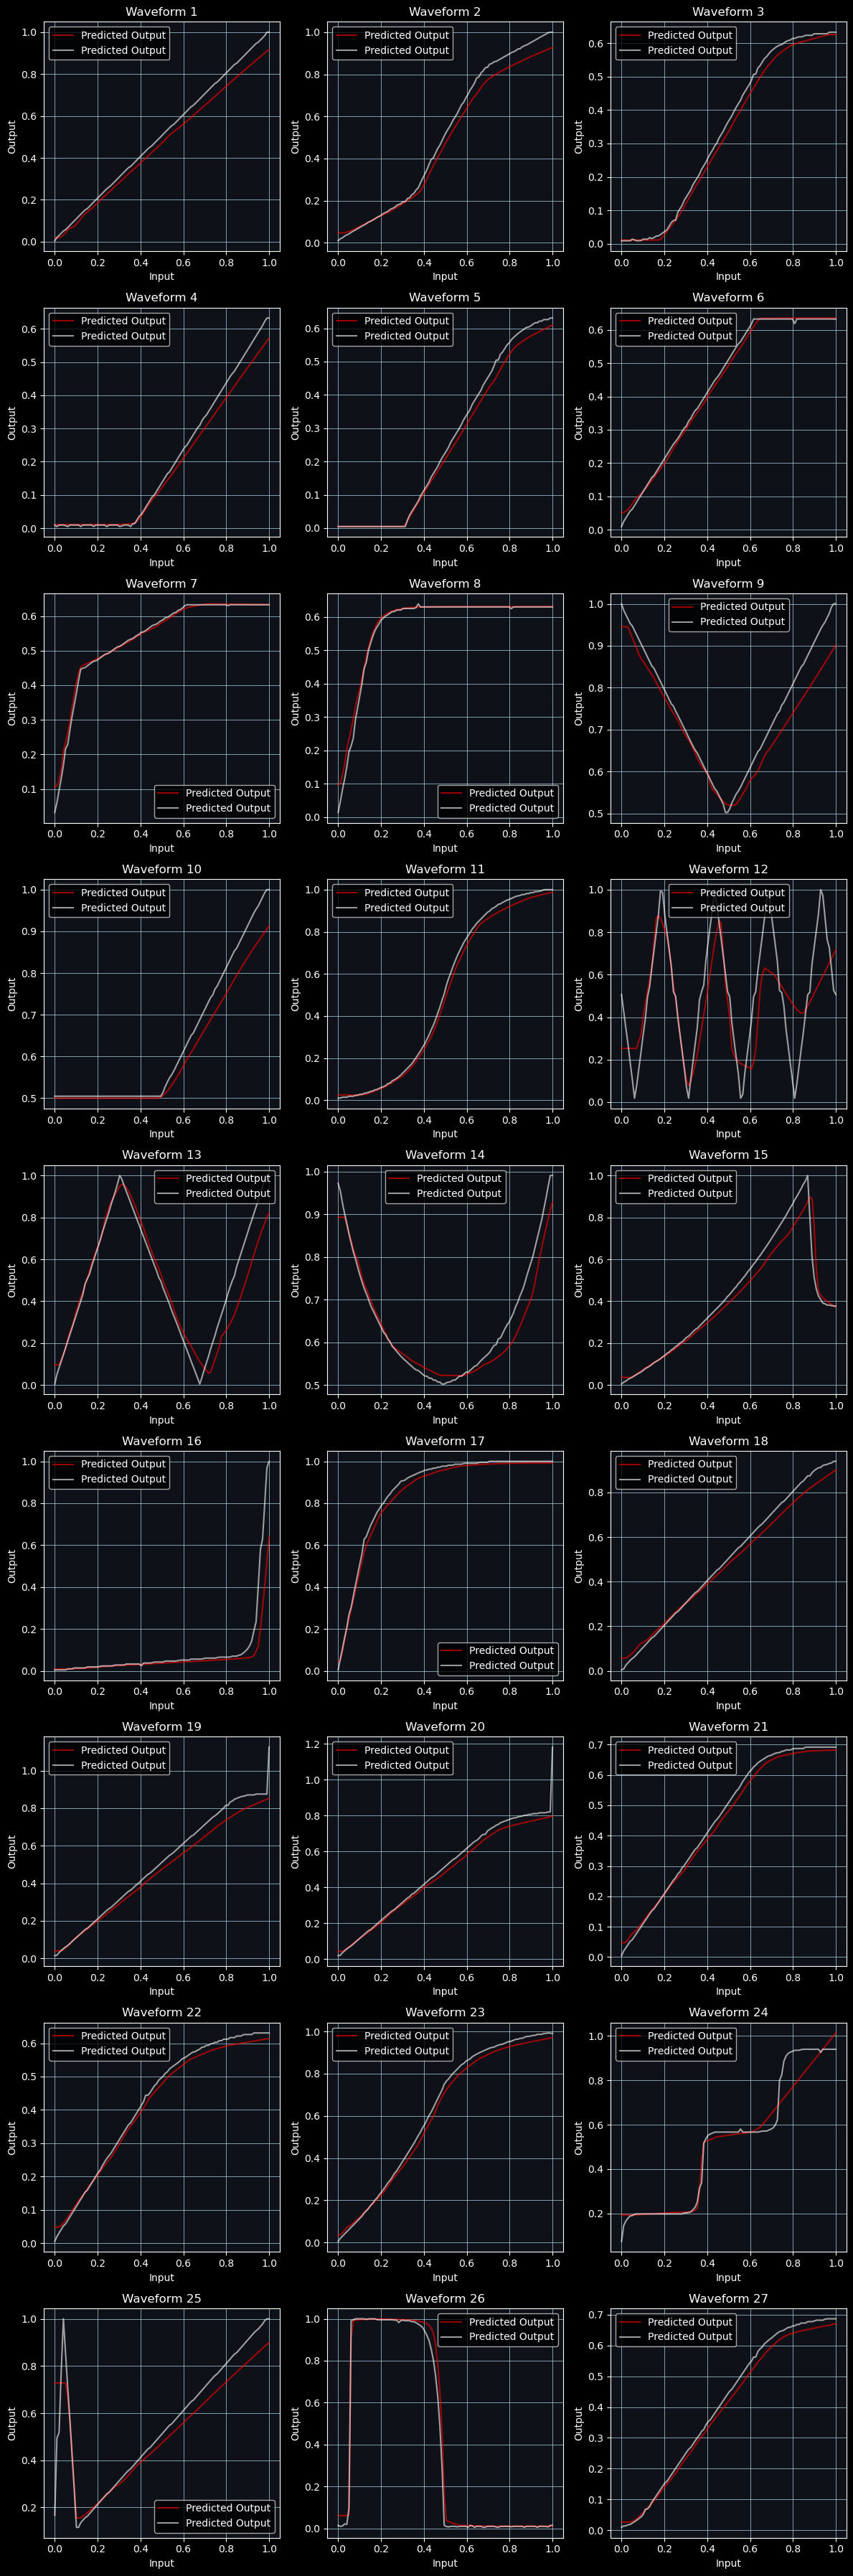

In [16]:
plot_waves(mlp_WaveShaper, classic_WaveShaper, mlps)

## 2. Linear Interpolation

In [312]:
class WaveShaperLinearInterpolationX(nn.Module):
    def __init__(self, n):
        super(WaveShaperLinearInterpolationX, self).__init__()
        # Initialize parameters with a linspace between 0 and 1
        self.n = n
        self.init_weights()

    def forward(self, x):
        # Ensure input x is within the range [0, 1]
        x = torch.clamp(x, 0, 1)

        # Scale x to match the parameter range
        x_scaled = x * (len(self.params) - 1)

        # Perform interpolation
        # Compute the indices of the nearest parameters for each x value
        indices = x_scaled.long()
        # Compute the fractional part to interpolate
        fractional = x_scaled - indices
        
        # Gather the nearest parameters
        lower_params = self.params[indices]
        upper_params = self.params[torch.clamp(indices + 1, max=len(self.params) - 1)]
        
        # Linear interpolation
        interpolated_values = lower_params + (upper_params - lower_params) * fractional

        return interpolated_values
    
    def init_weights(self):
        self.params = nn.Parameter(torch.linspace(0, 1, steps=self.n))
    
    def plot(self, axe, num_points=100):
        
        # Generate inputs and predictions
        self.eval()
        inputs = torch.linspace(0, 1, num_points).unsqueeze(1)
        predicted_output = self(inputs).detach()

        axe.plot(inputs.squeeze().numpy(), 
                 predicted_output.squeeze().numpy(), 
                 label='Predicted Output', 
                 color='red',alpha = 0.6)
        
        for indices, param in zip(torch.linspace(0, 1, steps=self.n),self.params):
            axe.vlines(indices.item(), ymin=0, ymax= param.item(), color='blue', linestyle='dotted')
            axe.scatter(indices.item(), param.item(),s=2, color='blue')


In [256]:
WaveShaper_LIX = WaveShaperLinearInterpolationX(6)
interps, losses = global_loss(WaveShaper_LIX,classic_WaveShaper)

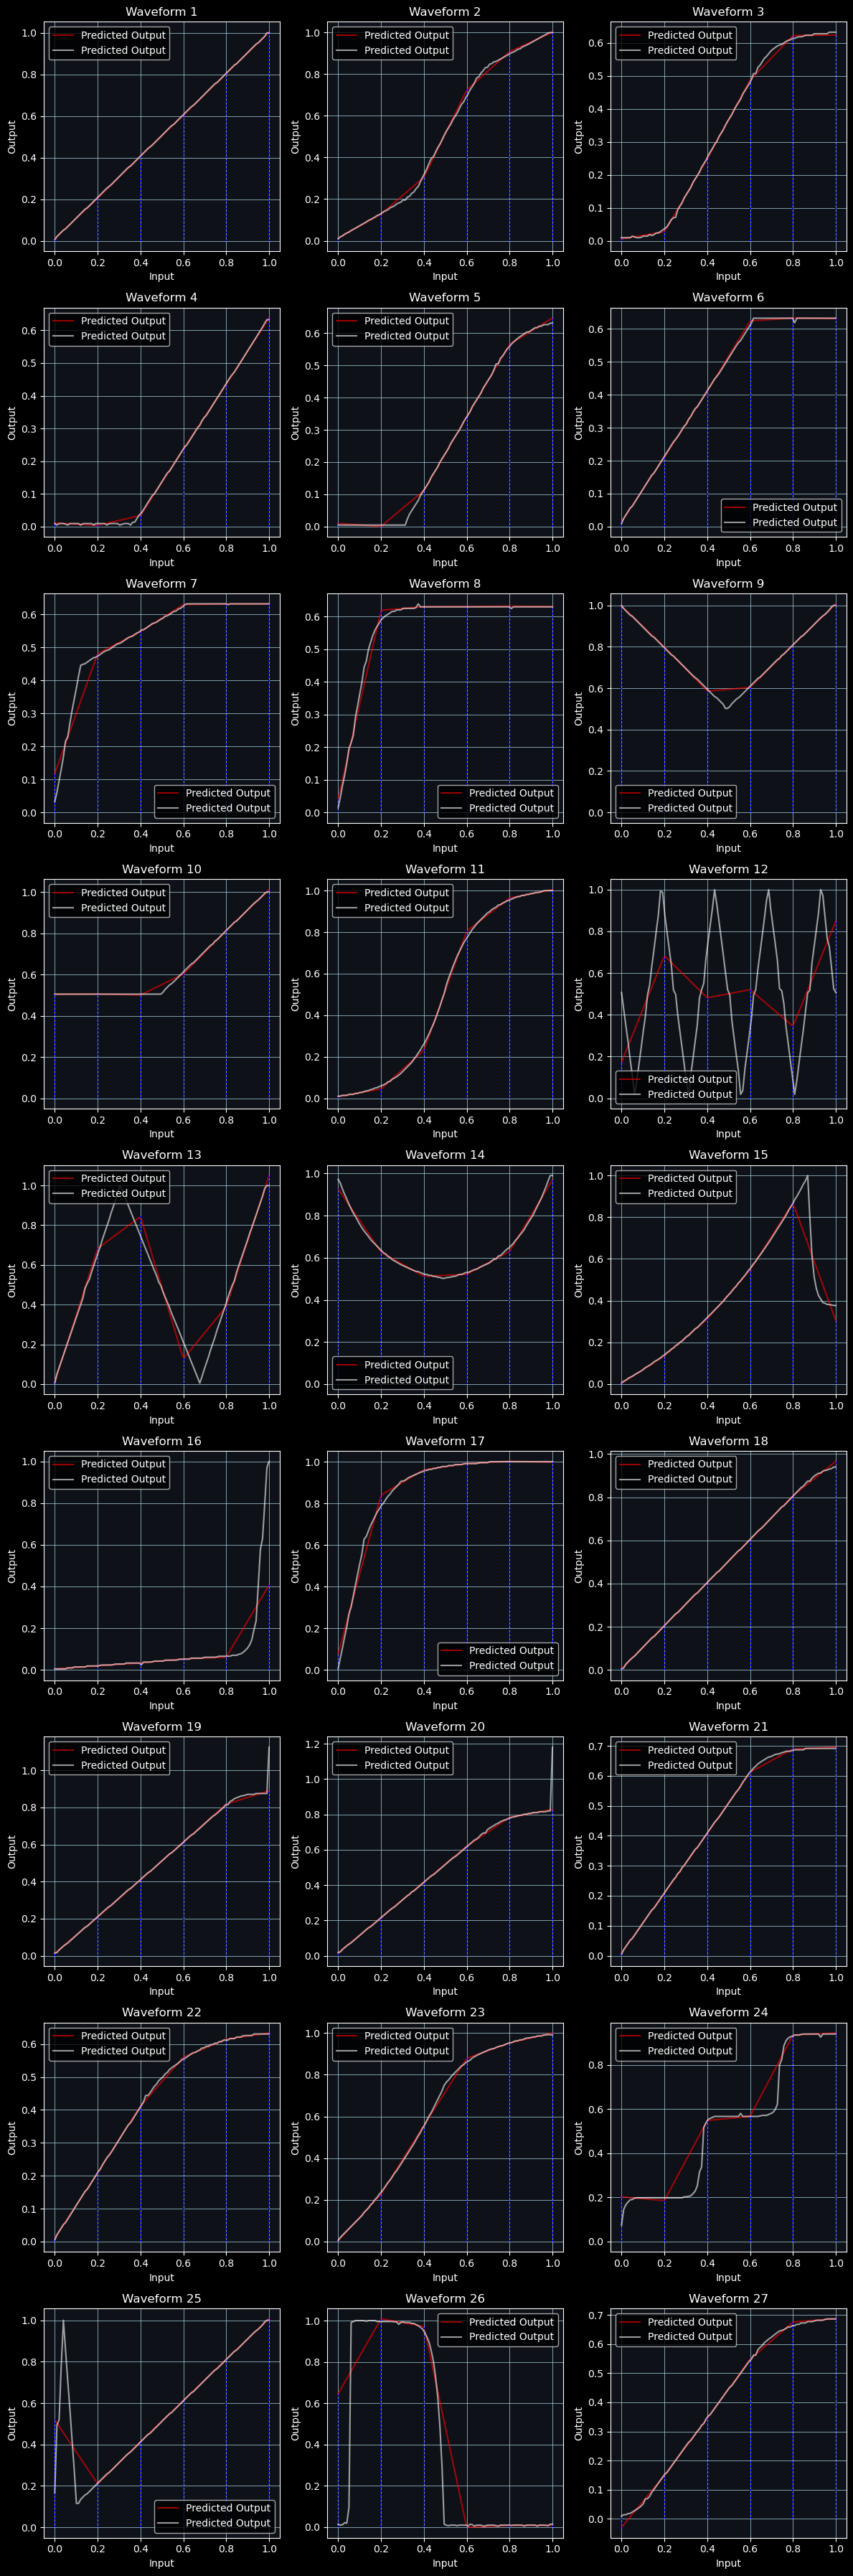

In [257]:
plot_waves(WaveShaper_LIX, classic_WaveShaper, interps)

## 3. Dynamic Interpolation

In [310]:
GRAD = []
VALUES = []

class WaveShaperDynamicInterpolationX(nn.Module):
    def __init__(self, n):
        super(WaveShaperDynamicInterpolationX, self).__init__()
        self.n = n
        self.init_weights()

    def forward(self, x):
        # Ensure input is within the range [0, 1]
        batch = x.shape[0]
        x = torch.clamp(x, 0, 1)
        
        # Compute distances
        dist = torch.stack([torch.linspace(0, 1, self.n)]*batch,dim=0)      
        dist = dist - x

        # Compute the distance to the 2 closest points
        var = torch.stack([self.params_var]*batch,dim=0)
        values, indices = torch.topk(-torch.abs(dist), 2, dim=-1)
        closest_vars = torch.gather(var, 1, indices)  # Shape [batch, 2]
        
        # Comute variance
        var_weights = 1.0 / (-values + 1e-6)  # Shape [batch, 2]
        var_weights = var_weights / var_weights.sum(dim=-1, keepdim=True)
        var = (closest_vars * var_weights).sum(dim=1,keepdim=True)
        var = 100 * F.sigmoid(var)

        # Compute rectified distance (using variance)
        dist = torch.exp(-0.5 * torch.abs(dist)*var)
        dist = dist/torch.sum(dist,dim=-1,keepdim=True)
        
        # Final interpolation
        weights = torch.stack([self.params]*batch,dim=0)
        interpolated_x = torch.sum(dist*weights,dim=-1,keepdim=True)

        return interpolated_x

    def init_weights(self):
        # Initialize parameters with a linspace between 0 and 1
        self.params = nn.Parameter(torch.linspace(0, 1, steps=self.n))
        self.params_var = nn.Parameter(torch.ones(self.n)*(-2))
    
    def plot(self, axe, num_points=100):
        
        # Generate inputs and predictions
        self.eval()
        inputs = torch.linspace(0, 1, num_points).unsqueeze(1)
        predicted_output = self(inputs).detach()

        axe.plot(inputs.squeeze().numpy(), 
                 predicted_output.squeeze().numpy(), 
                 label='Predicted Output', 
                 color='red',alpha = 0.6)
        
        for indices, param, var in zip(torch.linspace(0, 1, steps=self.n),self.params,self.params_var):
            axe.vlines(indices.item(), ymin=0, ymax= param.item(), color='blue', linestyle='dotted')
            axe.scatter(indices.item(), param.item(),s=F.sigmoid(var).item()*200 , color='blue')

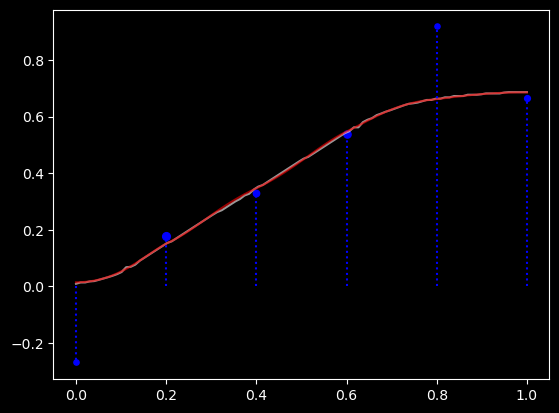

In [298]:
WaveShaper_DIX = WaveShaperDynamicInterpolationX(6)

WaveShaper_DIX = train_mlp(WaveShaper_DIX, classic_WaveShaper)

f, axe = plt.subplots(1)
classic_WaveShaper.plot(axe)
WaveShaper_DIX.plot(axe)

In [254]:
WaveShaper_DIX = WaveShaperDynamicInterpolationX(6)

interps, losses = global_loss(WaveShaper_DIX,classic_WaveShaper)

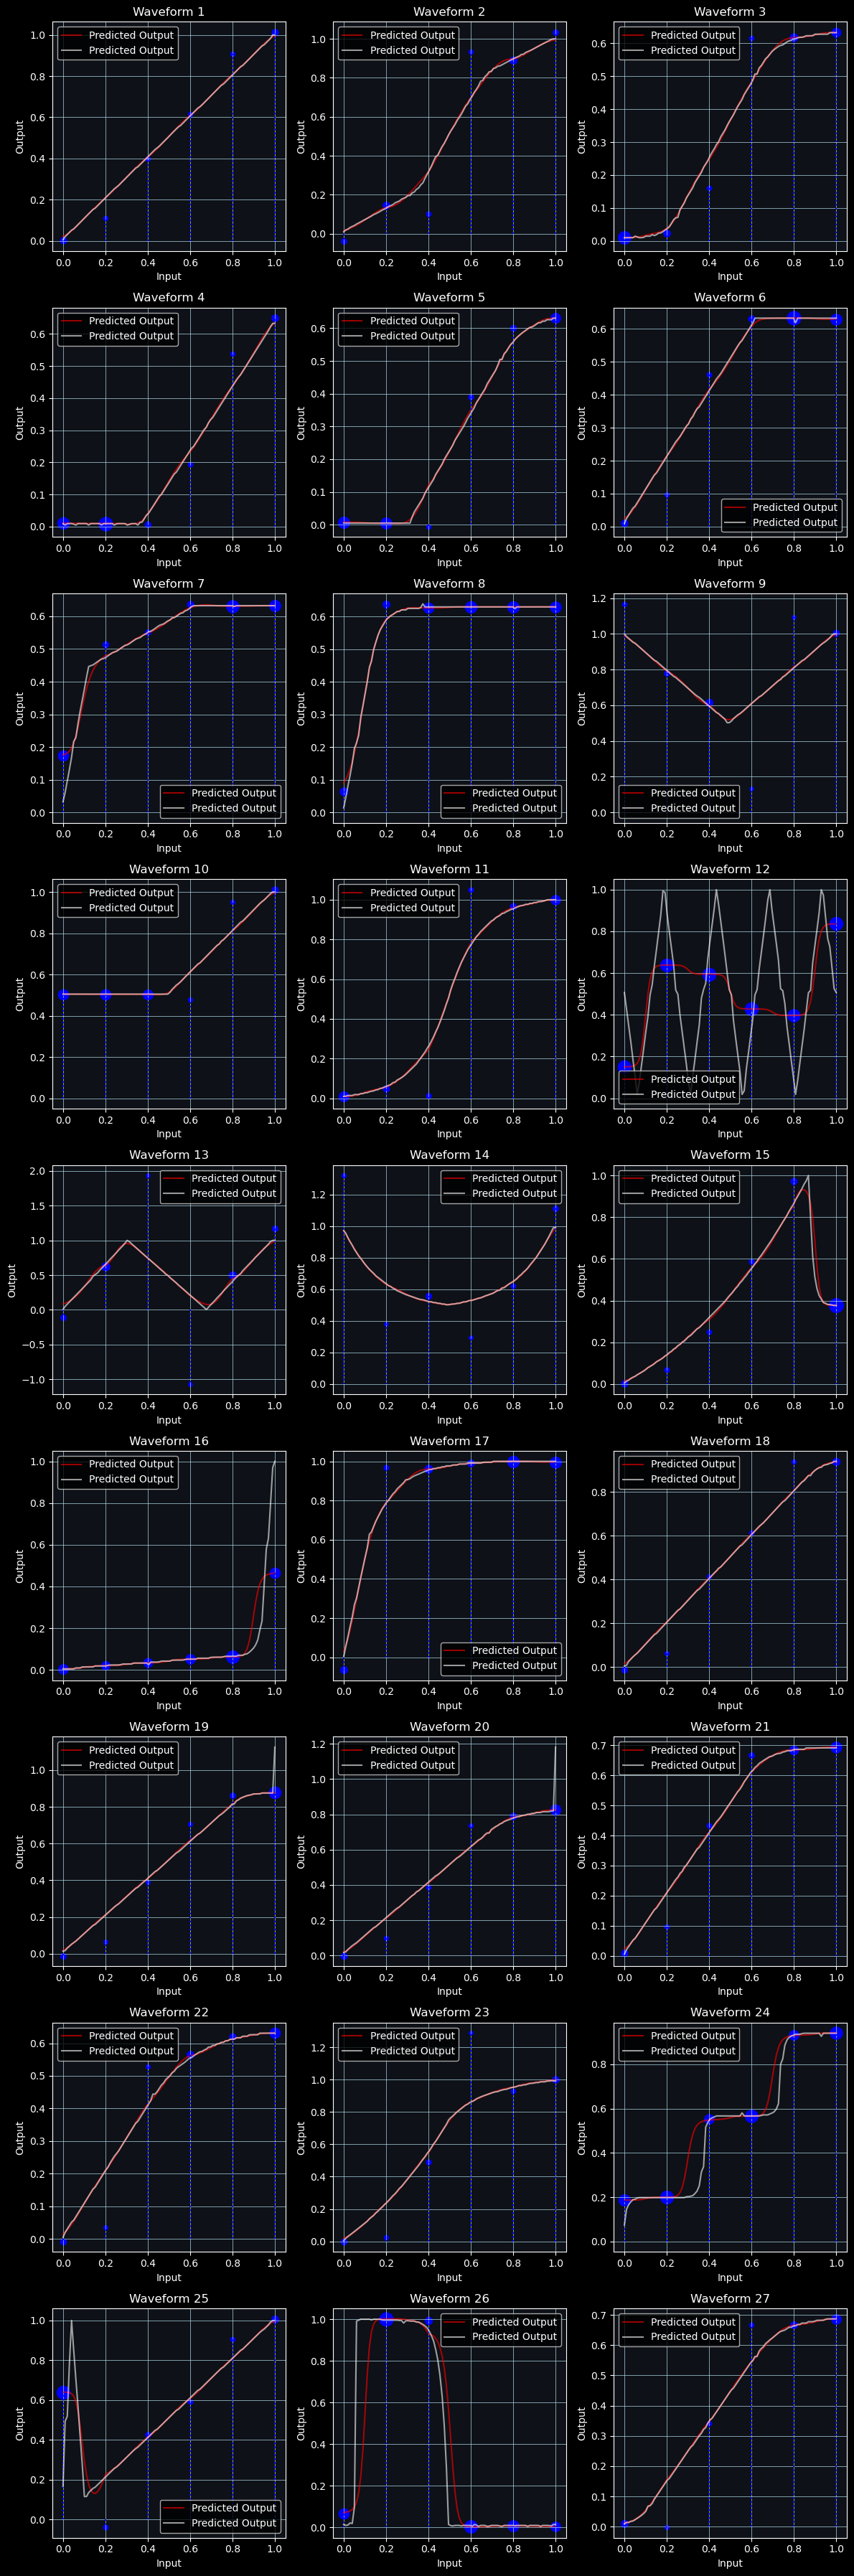

In [255]:
plot_waves(WaveShaper_DIX, classic_WaveShaper, interps)

## 4. XY DynamicInterpolation

In [299]:
class WaveShaperDynamicInterpolationXY(nn.Module):
    def __init__(self, n):
        super(WaveShaperDynamicInterpolationXY, self).__init__()
        self.n = n
        self.init_weights()

    def forward(self, x):
        batch = x.shape[0]
        x = torch.clamp(x, 0, 1)
        
        # Ensure stable boundary conditions
        self.params_X.data[0]=0
        self.params_X.data[-1]=1
        
        # Compute distances
        dist = torch.stack([self.params_X]*batch,dim=0)      
        dist = dist - x

        # Compute the distance to the 2 closest points
        var = torch.stack([self.params_var]*batch,dim=0)
        values, indices = torch.topk(-torch.abs(dist), 2, dim=-1)
        closest_vars = torch.gather(var, 1, indices)  # Shape [batch, 2]
        
        # Comute variance
        var_weights = 1.0 / (-values + 1e-6)  # Shape [batch, 2]
        var_weights = var_weights / var_weights.sum(dim=-1, keepdim=True)
        var = (closest_vars * var_weights).sum(dim=1,keepdim=True)
        var = 100 * F.sigmoid(var)

        # Compute rectified distance (using variance)
        dist = torch.exp(-0.5 *torch.abs(dist)*var)
        dist = dist/torch.sum(dist,dim=-1,keepdim=True)
        
        # Final Interpolation
        weights = torch.stack([self.params]*batch,dim=0)
        interpolated_x = torch.sum(dist*weights,dim=-1,keepdim=True)

        return interpolated_x

    def init_weights(self):
        # Initialize parameters with a linspace between 0 and 1
        self.params = nn.Parameter(torch.linspace(0, 1, steps=self.n))
        self.params_var = nn.Parameter(torch.ones(self.n))
        self.params_X = nn.Parameter(torch.linspace(0, 1, steps=self.n)) #[1:-1]
    
    def plot(self, axe, num_points=100):
        
        # Generate inputs and predictions
        self.eval()
        inputs = torch.linspace(0, 1, num_points).unsqueeze(1)
        predicted_output = self(inputs).detach()

        axe.plot(inputs.squeeze().numpy(), 
                 predicted_output.squeeze().numpy(), 
                 label='Predicted Output', 
                 color='red',alpha = 0.6)
        
        for indices, param, var, param_x in zip(torch.linspace(0, 1, steps=self.n),self.params,self.params_var,self.params_X):
            axe.vlines(param_x.item(), ymin=0, ymax= param.item(), color='blue', linestyle='dotted')
            axe.scatter(param_x.item(), param.item(),s=F.sigmoid(var).item()*200 , color='blue')

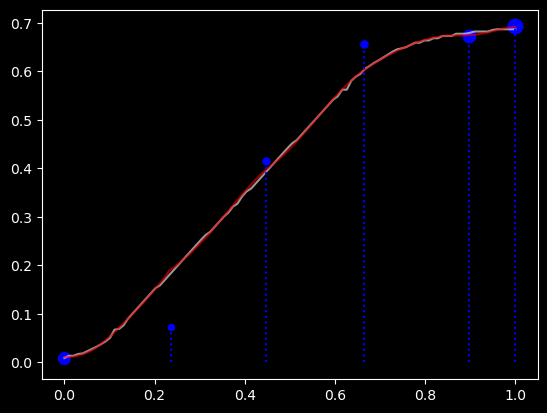

In [268]:
WaveShaper_DIXY = WaveShaperDynamicInterpolationXY(6)
WaveShaper_DIXY = train_mlp(WaveShaper_DIXY, classic_WaveShaper)

f, axe = plt.subplots(1)
classic_WaveShaper.plot(axe)
WaveShaper_DIXY.plot(axe)

In [269]:
WaveShaper_DIXY = WaveShaperDynamicInterpolationXY(6)

interps, losses = global_loss(WaveShaper_DIXY,classic_WaveShaper)

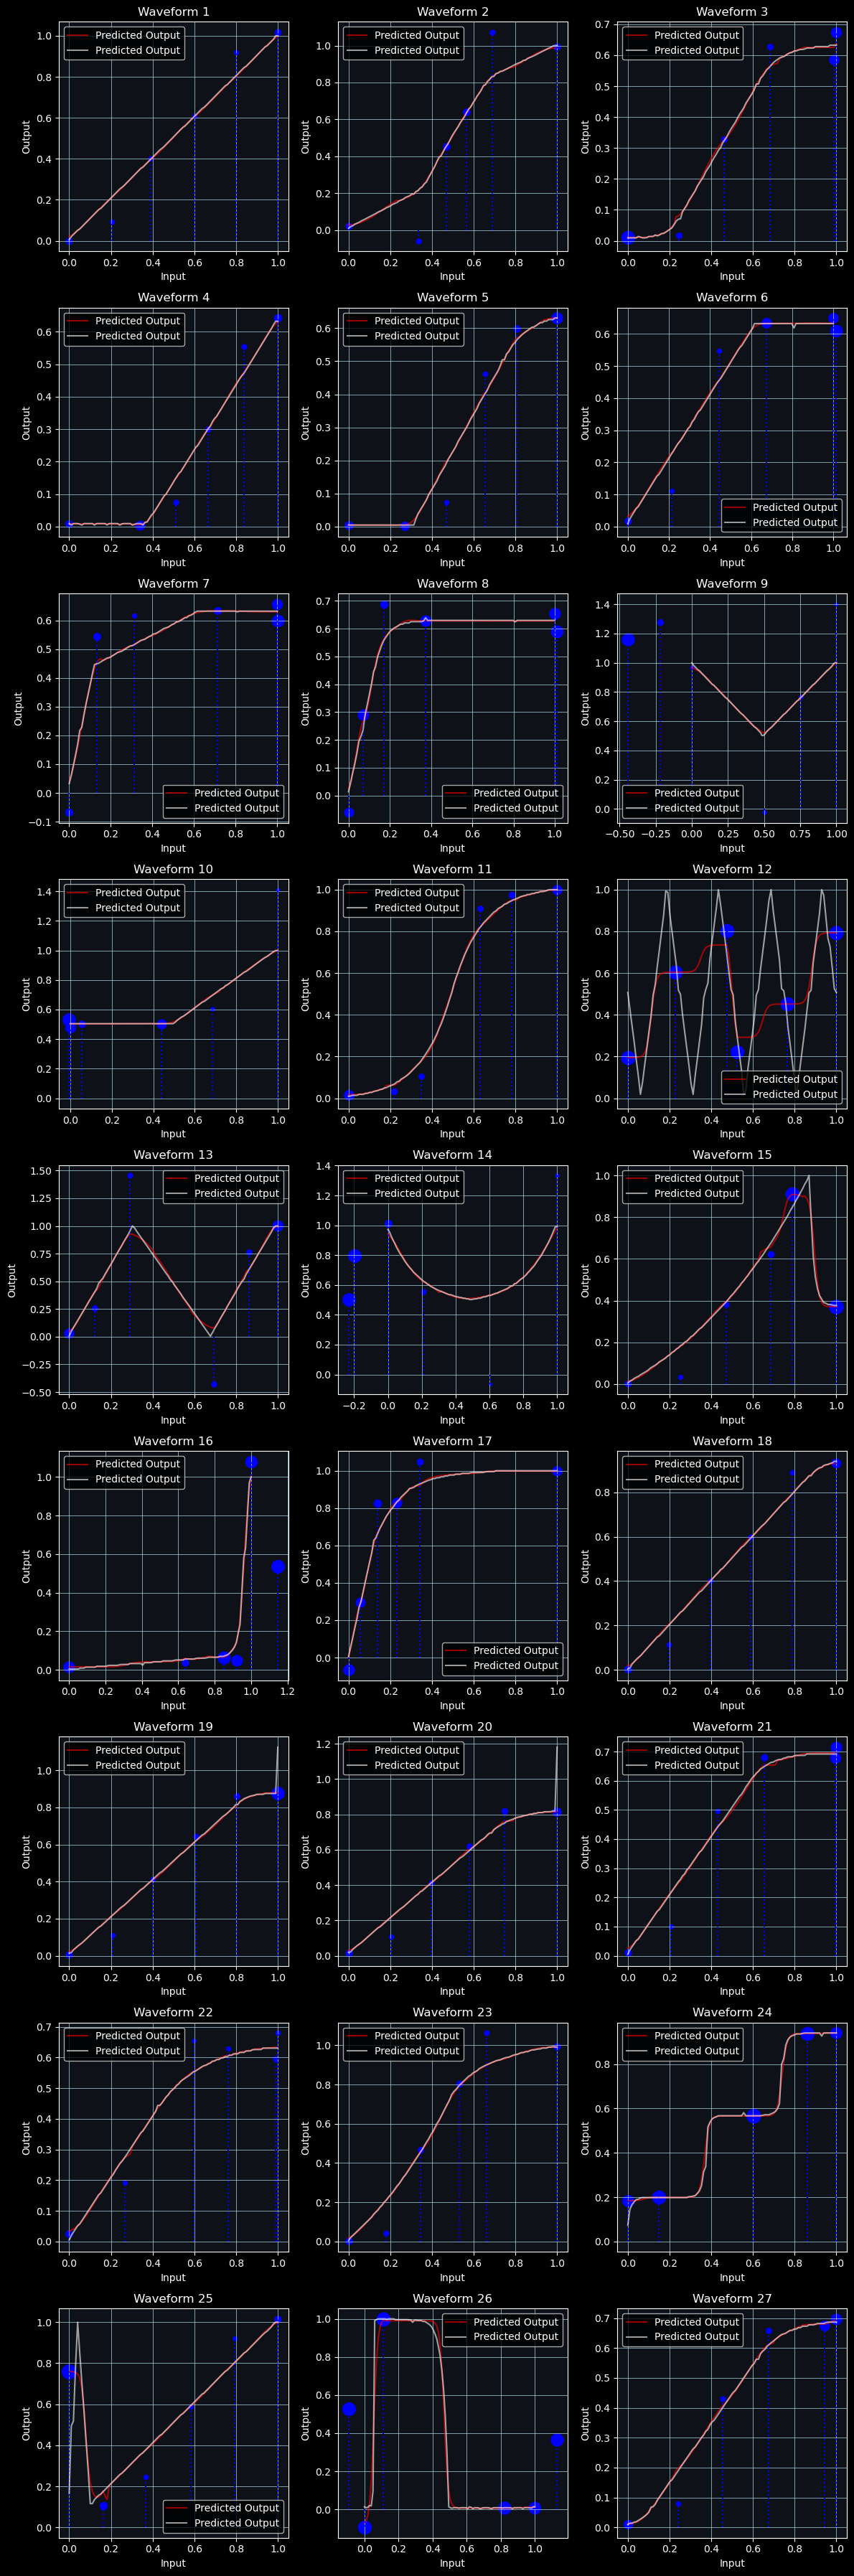

In [270]:
plot_waves(WaveShaper_DIXY, classic_WaveShaper, interps)

# Results

In [307]:
plt.style.use('default')

### Multi Layer Perceptron

In [325]:
min=3
max=12
diff = max - min

activations_list = [1, 0.5, 0]

MLP_losses_hist = []
MLP_param_number_hist = []

for n_1 in range(min,max):
    for n_2 in range(min,max):
        n = (n_2-min) + diff*(n_1-min)
        print(round(100*n/((max-min)**2)),"%",end="\r")
        WaveShaper_Differenciable = WaveShaperMLP([1, n_1, n_2, 1],activations_list)

        _, losses = global_loss(WaveShaper_Differenciable,WaveShaper_Classic)

        MLP_param_number_hist.append(n)
        MLP_losses_hist.append(np.sum(np.array(losses)))
print("Done ")

Done 


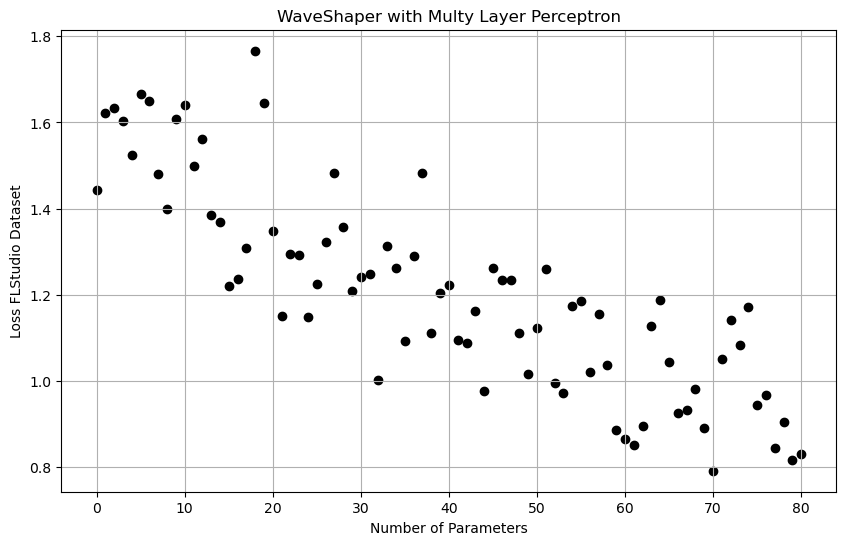

In [326]:
plt.figure(figsize=(10, 6))
plt.scatter(MLP_param_number_hist, MLP_losses_hist, marker='o', color='k')
plt.title('WaveShaper with Multy Layer Perceptron')
plt.xlabel('Number of Parameters')
plt.ylabel('Loss FLStudio Dataset')
plt.grid(True)
plt.show()

### Linear Intertilation in X

In [313]:
min=2
max=45
LIX_losses_hist = []
LIX_param_number_hist = []

for n in range(min,max):
    print(round(100*n/(max-min)),"%",end="\r")
    WaveShaper_Differenciable = WaveShaperLinearInterpolationX(n)

    _, losses = global_loss(WaveShaper_Differenciable,WaveShaper_Classic)

    LIX_param_number_hist.append(sum(p.numel() for p in WaveShaper_Differenciable.parameters() if p.requires_grad))
    LIX_losses_hist.append(np.sum(np.array(losses)))
print("Done ")

Done 


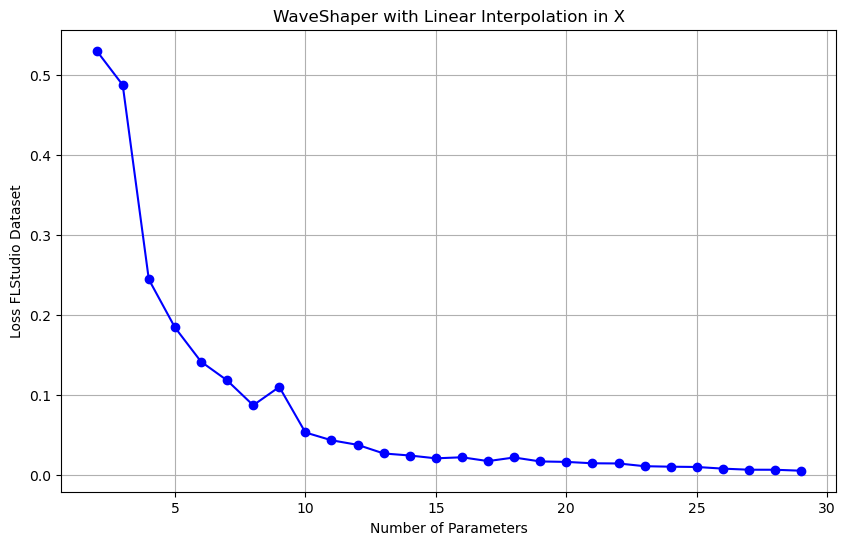

In [314]:
plt.figure(figsize=(10, 6))
plt.plot(LIX_param_number_hist, LIX_losses_hist, marker='o', linestyle='-', color='k')
plt.title('WaveShaper with Linear Interpolation in X')
plt.xlabel('Number of Parameters')
plt.ylabel('Loss FLStudio Dataset')
plt.grid(True)
plt.show()

### Dynamic Interpolation in X

In [315]:
min=2
max=30
DIX_losses_hist = []
DIX_param_number_hist = []

for n in range(min,max):
    print(round(100*n/(max-min)),"%",end="\r")
    WaveShaper_Differenciable = WaveShaperDynamicInterpolationX(n)

    _, losses = global_loss(WaveShaper_Differenciable,WaveShaper_Classic)

    DIX_param_number_hist.append(n*2)
    DIX_losses_hist.append(np.sum(np.array(losses)))
print("Done")

Done%


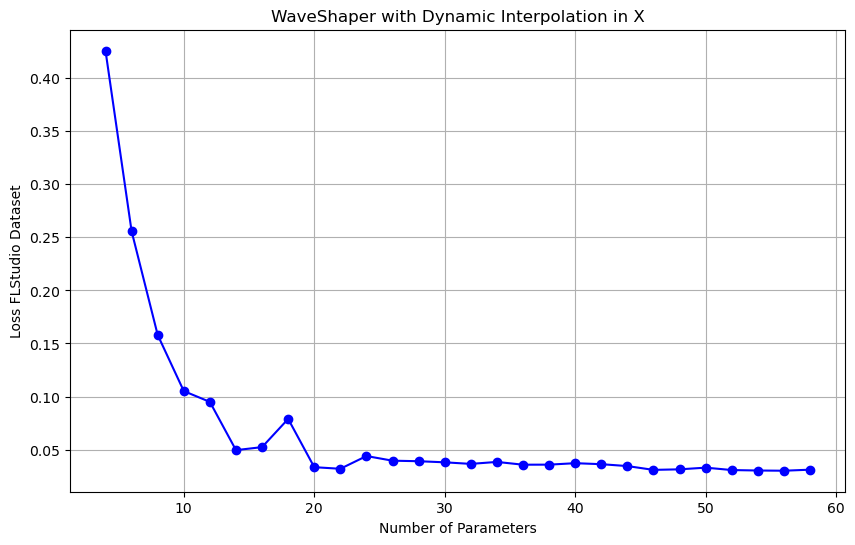

In [316]:
plt.figure(figsize=(10, 6))
plt.plot(DIX_param_number_hist, DIX_losses_hist, marker='o', linestyle='-', color='k')
plt.title('WaveShaper with Dynamic Interpolation in X')
plt.xlabel('Number of Parameters')
plt.ylabel('Loss FLStudio Dataset')
plt.grid(True)
plt.show()

### Dynamic Interpolation in X and Y

In [304]:
min=2
max=15
DIXY_losses_hist = []
DIXY_param_number_hist = []

for n in range(min,max):
    print(round(100*n/(max-min)),"%",end="\r")
    WaveShaper_Differenciable = WaveShaperDynamicInterpolationXY(n)

    _, losses = global_loss(WaveShaper_Differenciable,WaveShaper_Classic)

    DIXY_param_number_hist.append(n*3)
    DIXY_losses_hist.append(np.sum(np.array(losses)))
print("Done ")

Done%


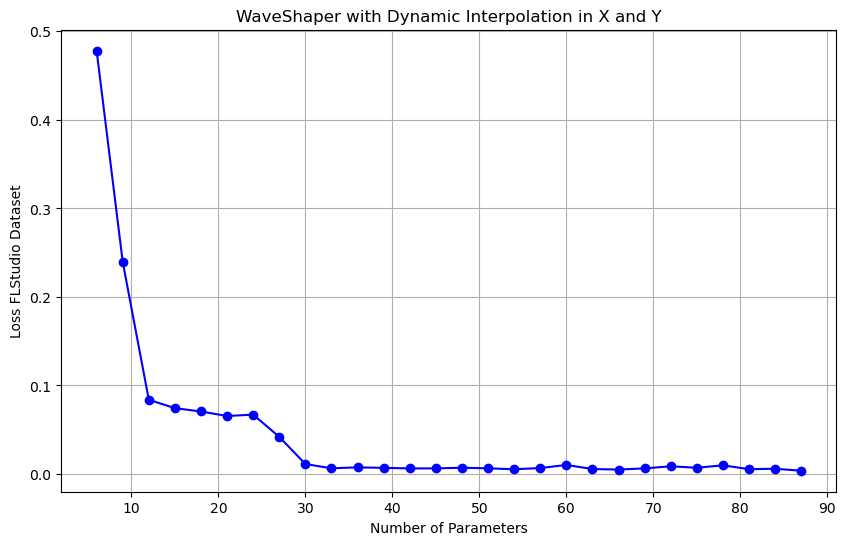

In [308]:
plt.figure(figsize=(10, 6))
plt.plot(DIXY_param_number_hist, DIXY_losses_hist, marker='o', linestyle='-', color='k')
plt.title('WaveShaper with Dynamic Interpolation in X and Y')
plt.xlabel('Number of Parameters')
plt.ylabel('Loss FLStudio Dataset')
plt.grid(True)
plt.show()

### All

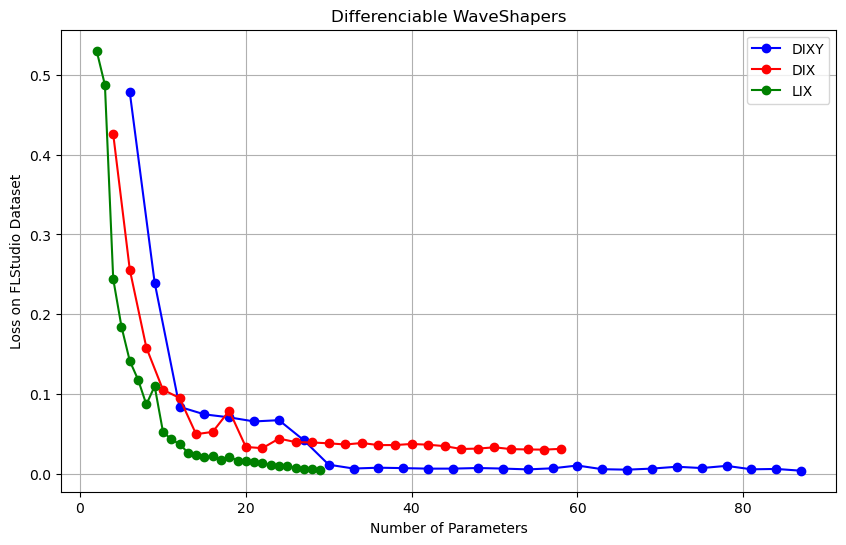

In [318]:
plt.figure(figsize=(10, 6))
plt.plot(DIXY_param_number_hist, DIXY_losses_hist, marker='o', linestyle='-', color='b', label="DIXY")
plt.plot(DIX_param_number_hist, DIX_losses_hist, marker='o', linestyle='-', color='r', label="DIX")
plt.plot(LIX_param_number_hist, LIX_losses_hist, marker='o', linestyle='-', color='g', label="LIX")
#plt.plot(MLP_param_number_hist, MLP_losses_hist, marker='o', linestyle='-', color='y', label="MLP")
plt.title('Differenciable WaveShapers')
plt.xlabel('Number of Parameters')
plt.ylabel('Loss on FLStudio Dataset')
plt.grid(True)
plt.legend()
plt.show()

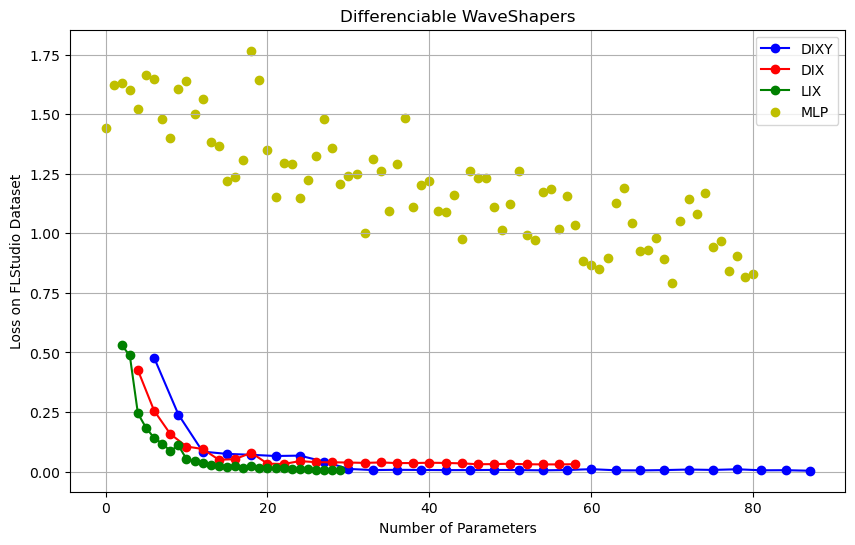

In [327]:
plt.figure(figsize=(10, 6))
plt.plot(DIXY_param_number_hist, DIXY_losses_hist, marker='o', linestyle='-', color='b', label="DIXY")
plt.plot(DIX_param_number_hist, DIX_losses_hist, marker='o', linestyle='-', color='r', label="DIX")
plt.plot(LIX_param_number_hist, LIX_losses_hist, marker='o', linestyle='-', color='g', label="LIX")
plt.scatter(MLP_param_number_hist, MLP_losses_hist, marker='o', color='y', label="MLP")
plt.title('Differenciable WaveShapers')
plt.xlabel('Number of Parameters')
plt.ylabel('Loss on FLStudio Dataset')
plt.grid(True)
plt.legend()
plt.show()